In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.utils.data as data
from tqdm.notebook import tqdm
from prettytable import PrettyTable
import time

In [20]:
# Hyperparameter variables. 
num_epochs = 25
batch_size = 10
learning_rate = 0.001
sequence_length = 25
save_name = input()

In [21]:
# Check if CUDA is available. 
# Set device to CUDA unless not available
if torch.cuda.is_available():
    print(f'CUDA is available on {torch.cuda.get_device_name(0)}. ')
    device = 'cuda'
else:
    print('CUDA is not available. ')
    device = 'cpu'

CUDA is available on NVIDIA GeForce RTX 4060 Laptop GPU. 


In [22]:
# Open text file containing Shakespeare's sonnets. 
# Clean text by removing line breaks, and making all letters lowercase. 
# Create vocavulary from text and define tokenization mappings. 
path_to_file = 'Plays.txt'
with open(path_to_file, 'r') as file: 
    text = file.read()
text = text.replace('\n', ' ').replace('\r', ' ').replace('"', '').replace('-','').replace('  ', ' ').replace('’', "'")
text = text.lower()

char_count = len(text)
word_count = len(text.split())
vocabulary = sorted(set(text))

char_to_idx = dict((char, idx) for idx, char in enumerate(vocabulary))
idx_to_char = dict((idx, char) for char, idx in char_to_idx.items())

print(f'Vocabulary size: {len(vocabulary)}.')
print(f'Character count: {char_count}. ')
print(f'Word count: {word_count}. ')

with open(f'Augment_Cleaned_{path_to_file}', 'w') as file: 
    file.write(text)

Vocabulary size: 37.
Character count: 1106260. 
Word count: 202651. 


In [23]:
# Split text into sequences, where sequence_in is characters n to n+100, and sequence_out is n+101. 
# Tokenize text using char_to_idx mapping. 
X_data = np.zeros((char_count - sequence_length, sequence_length), dtype=int)
y_data = np.zeros((char_count - sequence_length, 1), dtype=int)
for i in tqdm(range(0, char_count - sequence_length), desc='Tokenizing text'):
    X_data[i] = [char_to_idx[char] for char in text[i:i + sequence_length]]
    y_data[i] = char_to_idx[text[i + sequence_length]]
print(f'Number of training sequences: {X_data.shape[0]}.')

Tokenizing text:   0%|          | 0/1106235 [00:00<?, ?it/s]

Number of training sequences: 1106235.


In [24]:
# Embed imput data using one-hot encoding. 
# Convert X_data and y_data to tensors X and y.
X = torch.tensor(X_data, dtype=torch.long).reshape(len(X_data), sequence_length)
y = torch.tensor(y_data, dtype=torch.long).squeeze()

In [25]:
# Construct recurrent neural network model. 
# Use LSTM layer followed by dropout and single fully connected layer. 
class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(len(vocabulary), 10)
        self.lstm = nn.LSTM(input_size=10, hidden_size=500, num_layers=2, batch_first=True, dropout=0.3)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(500, len(vocabulary))
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.linear(self.dropout(x))
        return x

In [26]:
# Define model, optimizer, loss function, and dataloader. 
model = RNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size)

In [ ]:
# Train and validate model sequentially. 
# Send data to correct device when unpacking dataloader. 
# Print total loss at every epoch. 
# Save trained model. 
losses = []
for epoch in tqdm(range(num_epochs), desc='RNN training and validation'):
    model.train()
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    loss = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss += loss_fn(y_pred, y_batch)
        print(f'Epoch {epoch+1:02d}  Loss {loss:.2f}')
    losses.append(loss)
torch.save(model.state_dict(), f'{save_name}_State_Dict.pth')
torch.save(model, f'{save_name}_Full_Model.pth')

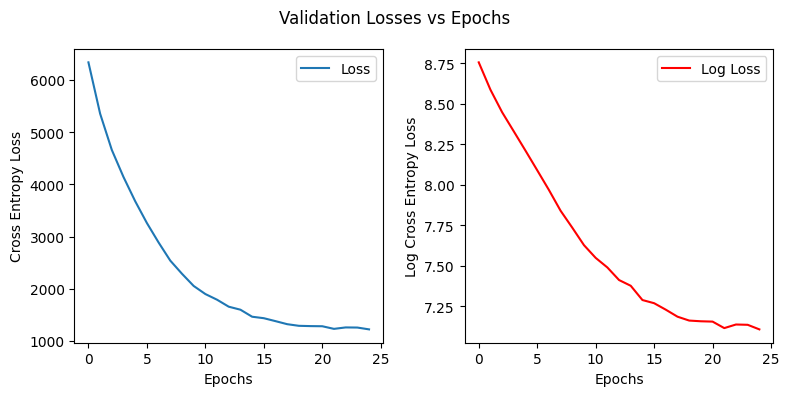

In [ ]:
# Generate Loss-Epoch plot and LogLoss-Epoch plot. 
float_losses = [loss.item() for loss in losses]
plt.figure(figsize=(8, 4))
plt.suptitle('Validation Losses vs Epochs')

plt.subplot(1, 2, 1)
plt.plot(float_losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.log(float_losses), label='Log Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Log Cross Entropy Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Generate model summary, showing all layers and parameters. 
table = PrettyTable(["Modules", "Parameters"])
total_params = 0
for name, parameter in model.named_parameters():
    if not parameter.requires_grad:
        continue
    params = parameter.numel()
    table.add_row([name, params])
    total_params += params
print(table)
print(f"Total Trainable Parameters: {total_params}")

+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
|  embedding.weight |    320     |
| lstm.weight_ih_l0 |   20000    |
| lstm.weight_hh_l0 |  1000000   |
|  lstm.bias_ih_l0  |    2000    |
|  lstm.bias_hh_l0  |    2000    |
| lstm.weight_ih_l1 |  1000000   |
| lstm.weight_hh_l1 |  1000000   |
|  lstm.bias_ih_l1  |    2000    |
|  lstm.bias_hh_l1  |    2000    |
|   linear.weight   |   16000    |
|    linear.bias    |     32     |
+-------------------+------------+
Total Trainable Params: 3044352


In [ ]:
# Generate text using trained model. 
# After each single-character prediction, step the prompt forward by one character. 
# Display prompt, response, and details about model. 
prompt = input().lower()
tokenized_prompt = [char_to_idx[c] for c in prompt]
print(f'Prompt: {prompt}')

with torch.no_grad(): 
    model.eval()    
    print(f'\nResponse: ', end='')
    for i in range(150):
        time.sleep(np.random.uniform(0.01, 0.05))
        x = torch.tensor(tokenized_prompt, dtype=torch.long).reshape(1, len(tokenized_prompt)).to(device)
        prediction = model(x)
        index = int(prediction.argmax())
        char = idx_to_char[index]
        tokenized_prompt.append(index)
        tokenized_prompt = tokenized_prompt[1:]
        print(char, end='')

print(f'\n\nBased on a learned vocabulary of {len(vocabulary)} characters. \nGenerated by a {total_params}-parameter RNN model. \nTrained on {word_count}-word corpus "{path_to_file}".')